In this notebook, I'm going to work on refactoring the code so far and implementing interactivity. This will give us more control over tweaking $A_1$-$A_5$ when we need to fine tune the model.

In [17]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd
import math
%matplotlib inline

In [18]:
DATA_PATH = 'data\\cmf100_example_data.csv'
data = pd.read_csv(DATA_PATH)
data

,mdot_lb_min,dp_psi
0,13,0.05
1,40,0.19
2,60,0.32
3,80,0.49
4,111,0.82
5,120,0.93
6,140,1.19
7,160,1.48
8,180,1.81
9,210,2.35


In [105]:
def V_out(m_dot, rho, A):
    '''
    m_dot comes in as lb/min, need to convert to    ft/s
    '''
    return ((m_dot/2)/(rho*A))*.024797

def A_out(ID):
    return math.pi*((ID/2)**2)

def D_H(ID, WP=1, circular=True):
    if(circular):
        return ID
    else:
        A = A_out(ID)
        return (4*A)/WP

def f_out(Re, Dh, e=1.524e-6):
    return (-1.8*np.log10((6.9/Re)+((e/Dh)/3.7)**1.11))**-2

def K_B(R, Dh):
    x = R / Dh
    return (1e-4)*(x**4)-(3.5e-3)*(x**3)+3.18e-2*(x**2)-.1382*x+.3288

def dP_curve_fit(m_dot, B1, B2):
    return B1*(m_dot**2)+B2*m_dot

def dP_curve_coefs(m_dot, dp_exp):
    xdata = m_dot
    ydata = dp_exp
    xdata_scaled = xdata / 100
    pop_dp_scaled, pconv_dp = curve_fit(dP_curve_fit, xdata_scaled, ydata)
    B1 = pop_dp_scaled[0] / (100**2)
    B2 = pop_dp_scaled[1] / 100
    return [B1, B2]

def coefs_out(Re, Km):
    xdata = Re[1:]
#     xdata = Re
    xdata_scaled = xdata*10**-4
    ydata = Km[1:]
#     ydata = Re
    popt_scaled, pcov = curve_fit(K_M, xdata_scaled, ydata)
    A1 = popt_scaled[0]
    A2 = popt_scaled[1]
    A3 = popt_scaled[2] / 10000
    A4 = popt_scaled[3]
    A5 = popt_scaled[4] / 10000
    return [A1, A2, A3, A4, A5]

def K_M(Re, A1, A2, A3, A4, A5):
    return A1 + A2*np.exp(-A3*Re) + A4*np.exp(-A5*Re)

def Re_out(rho, V, Dh, mu):
    return (rho*V*Dh / mu)*(1/3.28)

def dP(rho, V, L, f, n_bends, angle_bend, Kb, Km, Dh):
    return (rho*(V**2)/(2*3.28**2))*(f*(L/Dh) + (n_bends*angle_bend/90)*Kb +Km)

def generate_pd_df(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R):
    A = A_out(ID)
    Dh = D_H(ID)
    new_df = pd.DataFrame(columns=['mdot_lb_min','dp_psi_exp','dp_psi_pred','V','Re','f_Haaland','K_B','K_M_1','K_M_2','dp_Pa', 'dp_psi'])
    new_df['mdot_lb_min'] = m_dot
    new_df['dp_psi_exp'] = dp_psi_exp
    new_df['V'] = new_df['mdot_lb_min'].apply(lambda x: V_out(x, rho, A))
    new_df['Re'] = new_df['V'].apply(lambda x: Re_out(rho, x, Dh, mu))
    new_df['f_Haaland'] = new_df['Re'].apply(lambda x: f_out(x, Dh))
    new_df['K_B'] = K_B(R, Dh)
    [B1, B2] = dP_curve_coefs(new_df['mdot_lb_min'], new_df['dp_psi_exp'])
    new_df['dp_psi_pred'] = dP_curve_fit(new_df['mdot_lb_min'], B1, B2)
    new_df['K_M_1'] =  74179.2*(2*new_df['dp_psi_pred']/(rho*(new_df['V']**2))) - (new_df['f_Haaland']*(.966216/Dh)) - (2*(135/90)*new_df['K_B'])
    [A1, A2, A3, A4, A5] = coefs_out(new_df['Re'], new_df['K_M_1'])
    new_df['K_M_2'] = new_df['Re'].apply(lambda x: K_M(x, A1, A2, A3, A4, A5))
    new_df['dp_Pa'] = dP(rho, new_df['V'], L, new_df['f_Haaland'], n_bends, angle_bend, new_df['K_B'], new_df['K_M_2'],Dh)
    new_df['dp_psi'] = new_df['dp_Pa']*(1.45038e-4)
    return new_df, [A1, A2, A3, A4, A5]

In [106]:
rho = 1000 # kg/m^3
mu = 1e-3 # Pa*s
ID = .0164338 # m
L = .966216 # m
n_bends = 2
angle_bend = 135 # deg
R = .0508 # m
m_dot = data['mdot_lb_min']
dp_psi_exp = data['dp_psi']

[dP_df, coefs] = generate_pd_df(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R)

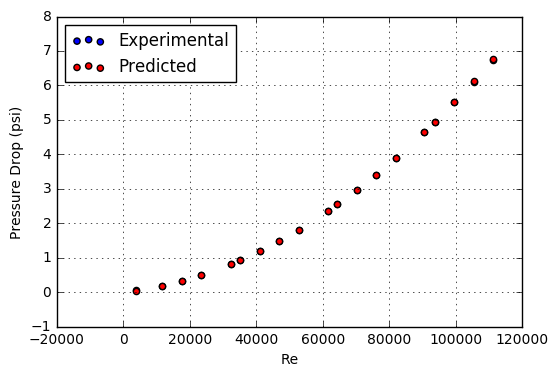

In [119]:
plt.scatter(dP_df['Re'], dP_df['dp_psi_exp'], c='b', label='Experimental')
plt.scatter(dP_df['Re'], dP_df['dp_psi'], c='r', label='Predicted')
plt.xlabel('Re')
plt.ylabel('Pressure Drop (psi)')
plt.legend(loc=2)
plt.grid(True)

In [108]:
dP_df

,mdot_lb_min,dp_psi_exp,dp_psi_pred,V,Re,f_Haaland,K_B,K_M_1,K_M_2,dp_Pa,dp_psi
0,13,0.05,0.046693,0.759883,3807.244573,0.041114,0.11121,9.246156,6.272740,242.156965,0.035122
1,40,0.19,0.185344,2.338101,11714.598687,0.029691,0.11121,2.950660,2.949655,1277.690529,0.185314
2,60,0.32,0.324318,3.507151,17571.898030,0.026740,0.11121,2.005989,2.011314,2239.214261,0.324771
3,80,0.49,0.494159,4.676202,23429.197373,0.024916,0.11121,1.554111,1.547059,3400.063447,0.493138
4,111,0.82,0.818417,6.488230,32508.011355,0.023073,0.11121,1.194075,1.192346,5639.603103,0.817957
5,120,0.93,0.926447,7.014303,35143.796060,0.022667,0.11121,1.127282,1.127809,6389.056501,0.926656
6,140,1.19,1.188892,8.183353,41001.095403,0.021898,0.11121,1.012722,1.016312,8208.589889,1.190557
7,160,1.48,1.482206,9.352404,46858.394746,0.021268,0.11121,0.929991,0.933945,10235.885847,1.484592
8,180,1.81,1.806387,10.521454,52715.694089,0.020737,0.11121,0.868004,0.870623,12468.519087,1.808409
9,210,2.35,2.350537,12.275030,61501.643104,0.020077,0.11121,0.800309,0.799989,16204.718980,2.350300


In [109]:
coefs

[0.62093362697545063,
 7.4959445446781752,
 0.00015743612546199643,
 1.7697036108002682,
 3.729145931990338e-05]

In [112]:
def plot_dP_adj(a1, a2, a3, a4, a5):
    m_dot = np.linspace(10,400,200)
    rho = 1000 # kg/m^3
    ID = .0164338 # m
    A = A_out(ID)
    mu = 1e-3 # Pa*s
    n_bends = 2
    angle_bend = 135 # deg
    R = .0508 # m
    Dh = D_H(ID)
    V = V_out(m_dot, rho, A)
    Re = Re_out(rho, V, Dh, mu)
    f = f_out(Re, Dh)
    Km = K_M(Re, a1, a2, a3, a4, a5)
    Kb = K_B(R, Dh)
    dP = (rho*(V**2)/(2*3.28**2))*(f*(L/Dh) + (n_bends*angle_bend/90)*Kb +Km)*(1.45038e-4) # psi
#     plt.plot(Re, dP,'r-')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlabel('Re')
#     plt.ylabel('Pressure Drop (psi)')
#     plt.xlim([10**3, 10**6])
#     plt.ylim([10**-2, 10**2])
    return Re, dP

def generate_dP_curve(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R, dP_df, A1, A2, A3, A4, A5):
    A = A_out(ID)
    mdot_in = np.linspace(m_dot.min(), m_dot.max(), 1000)
    V = V_out(m_dot, rho, A)
    Dh = D_H(ID)
    Re = Re_out(rho, V, Dh, mu)
    f = f_out(Re, Dh)
    Kb = K_B(R, Dh)
    Km = K_M(Re, A1, A2, A3, A4, A5)
    dP_out = dP(rho, V, L, f, n_bends, angle_bend, Kb, Km, Dh)*(1.45038e-4)
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.scatter(dP_df['Re'], dP_df['K_M_1'], c='b', label='Experimental Data')
    x_in = np.linspace(1, 1e8, 100000)
#     ax1.plot(dP_df['Re'], K_M(dP_df['Re'], A1, A2, A3, A4, A5), 'r-')
    ax1.plot(x_in,K_M(x_in, A1, A2, A3, A4, A5), 'r-', label='Curve Fit')
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim([10**(-3), 10**3])
    plt.xlabel('Re')
    plt.ylabel('$K_M$')
    plt.title('$K_M$ vs Re')
    plt.grid(True)
    plt.legend()
    
    ax2 = fig.add_subplot(1,2,2)
    [Re, dP_out] = plot_dP_adj(A1, A2, A3, A4, A5)
    ax2.scatter(dP_df['Re'], dP_df['dp_psi_exp'], c='b', label='Experimental Data')
    ax2.plot(Re, dP_out, c='r', label='Curve Fit')
    plt.xlabel('Re')
    plt.ylabel('Pressure Drop (psi)')
    plt.title('Pressure Drop vs Re')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.legend()
    return ax1, ax2
    
    

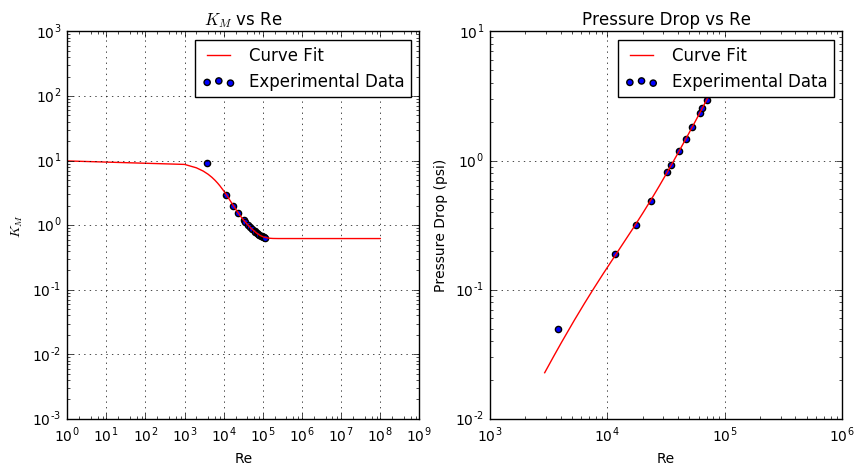

In [113]:
m_dot_in = dP_df['mdot_lb_min']
A1 = coefs[0]
A2 = coefs[1]
A3 = coefs[2]
A4 = coefs[3]
A5 = coefs[4]
[ax1, ax2] = generate_dP_curve(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R, dP_df, A1, A2, A3, A4, A5)

### Implementing widgets to control $A_1$ - $A_5$

In [114]:
import ipywidgets as widgets
from ipywidgets import interact

In [122]:
def plot_new(a1,a2,a3,a4,a5):
    [dP_df, coefs] = generate_pd_df(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R)
    [ax1, ax2] = generate_dP_curve(rho, m_dot, dp_psi_exp, mu, ID, L, n_bends, angle_bend, R, dP_df, A1, A2, A3, A4, A5)
    x_in = np.linspace(1, 1e8, 100000)
    ax1.plot(x_in,K_M(x_in, a1, a2, a3, a4, a5), 'g-', label='Adj Curve Fit')
    ax1.legend()
    
    [Re, dP_out] = plot_dP_adj(a1,a2,a3,a4,a5)
    ax2.plot(Re, dP_out, 'g-', label='Adj Curve Fit')
    ax2.legend(loc=4)

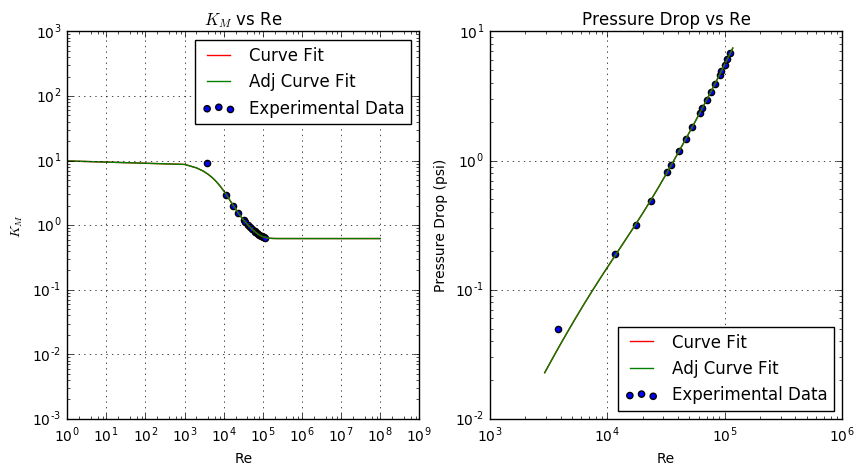

In [124]:
adj_plots = interact(plot_new,
             a1=widgets.BoundedFloatText(value=A1, description='A1'), 
             a2=widgets.BoundedFloatText(value=A2, description='A2'),
             a3=widgets.BoundedFloatText(value=A3, description='A3'), 
             a4=widgets.BoundedFloatText(value=A4, description='A4'), 
             a5=widgets.BoundedFloatText(value=A5, description='A5'),
             )